[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/costaalv/descobrindo_caos/blob/main/notebooks/13_varreduras_escala.ipynb)

# 13 · A Universalidade do Caos - Varreduras de Escala

**Registro observacional associado ao livro**  
*Descobrindo o Caos nos Números — Como a ordem emerge quando mudamos a forma de observar*  
© Alvaro Costa, 2025  

Este notebook faz parte de uma sequência canônica de registros computacionais.  
Ele não introduz hipóteses, conjecturas ou modelos interpretativos novos.

Seu objetivo é exclusivamente **registrar** o comportamento de estruturas aritméticas sob um regime  
de observação explícito, determinístico e reproduzível.

A leitura conceitual completa encontra-se no livro. Este notebook documenta apenas o experimento  
correspondente.

**Licença:** Creative Commons BY–NC–ND 4.0  
É permitida a leitura, execução e citação.  
Não é permitida a modificação, redistribuição adaptada ou uso comercial independente.

## 1. Uma Lei Local ou Universal?

Nos capítulos anteriores, identificamos um resultado notável: ao observar os números primos através da lente da **escala logarítmica**, o espectro  
do operador construído a partir de $\Delta_\pi(x)$ exibe a assinatura estatística da **GOE**, a marca do caos quântico.

Até aqui, porém, essa observação foi feita fixando a análise em uma vizinhança específica da reta numérica, por exemplo em torno de $X_0 = 10^8$.

Surge então a pergunta inevitável: **trata-se de um fenômeno local ou de uma lei universal?**

A “música” que ouvimos em $10^8$ é a mesma que se manifestaria em $10^5$ ou $10^3$? Ou estamos apenas a observar um efeito contingente, dependente  
da posição escolhida na reta?

A Teoria de Matrizes Aleatórias fornece uma previsão clara: em sistemas genuinamente caóticos, as estatísticas espectrais são **universais**, isto é,  
independentes dos detalhes microscópicos do sistema. Se a conexão entre primos e GOE for estrutural — e não acidental — ela deve persistir sob  
deslocamentos de escala.

Este notebook é dedicado a testar explicitamente essa hipótese de universalidade.

---

## 2. O Experimento: Uma Varredura Através das Magnitudes

Para investigar a robustez do fenômeno, realizamos uma **varredura de escala**. Mantemos fixa a construção do operador e a lente logarítmica, variando  
apenas o ponto inicial $X_0$ ao longo de várias ordens de magnitude.

Concretamente, repetimos a análise espectral para valores de $X_0$ que vão de $10^3$ até $10^8$.

Em cada escala, extraímos uma das assinaturas mais estáveis da GOE: a **média da razão de espaçamentos adjacentes**, denotada por $\langle r \rangle$.

Esta estatística tem duas vantagens fundamentais:
- independe de normalizações globais;
- permite distinguir de forma clara entre regimes de Poisson e GOE.

**Hipótese experimental:**  
se o regime GOE for universal, o valor de $\langle r \rangle$ deverá permanecer aproximadamente constante e próximo do valor teórico da GOE  
($\langle r \rangle \approx 0.536$), independentemente da escala $X_0$.


--- Pré-calculando todos os primos necessários ---
-> 28,715,862 primos gerados em 2.04 segundos.

--- Analisando escala em X₀ = 1000 ---

--- Analisando escala em X₀ = 10000 ---

--- Analisando escala em X₀ = 100000 ---

--- Analisando escala em X₀ = 1e+06 ---

--- Analisando escala em X₀ = 1e+07 ---

--- Analisando escala em X₀ = 1e+08 ---


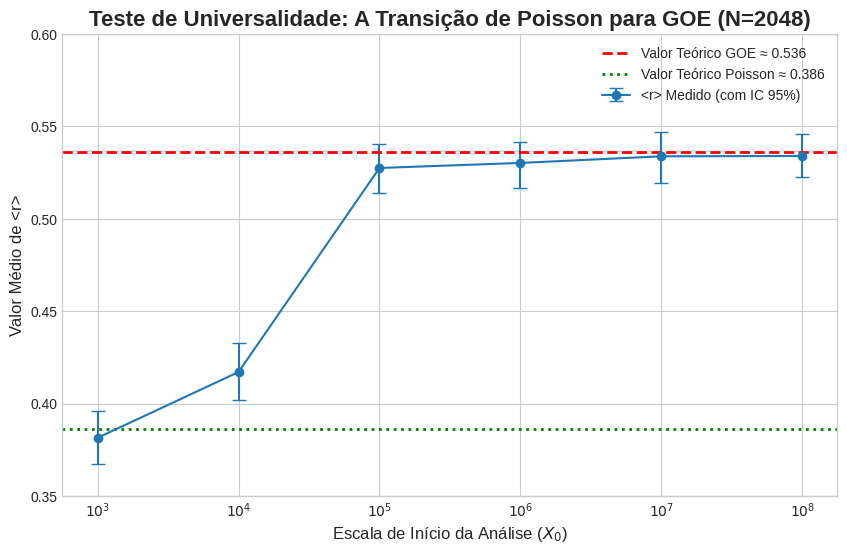

In [1]:
# Requisitos: pandas, matplotlib, numpy, ipywidgets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
import time

# --- Funções de Geração de Dados e Matriz (do capítulo anterior) ---
def generate_pi_data(n: int) -> np.ndarray:
    """Gera um array com todos os primos até n usando um crivo otimizado."""
    if n < 2: return np.array([], dtype=np.int64)
    size = (n - 1) // 2; sieve = np.ones(size, dtype=bool)
    limit = int(np.sqrt(n)) // 2
    for i in range(limit):
        if sieve[i]:
            p = 2 * i + 3; start = (p*p - 3) // 2
            sieve[start::p] = False
    indices = np.where(sieve)[0]; odd_primes = 2 * indices + 3
    return np.concatenate((np.array([2], dtype=np.int64), odd_primes))

def get_delta_pi_for_points(x_points, primes):
    """Calcula Δπ(x) para um array de pontos x usando uma lista de primos pré-calculada."""
    x_int = np.floor(x_points).astype(int)
    pi_x = np.searchsorted(primes, x_int, side='right')
    pi_x_div_2 = np.searchsorted(primes, x_int // 2, side='right')
    return pi_x - 2 * pi_x_div_2
    
def generate_cos_matrix(fx_values, x_values):
    fx = fx_values.astype(np.float64); x = x_values.astype(np.float64)
    x[x <= 0] = 1e-12; logx = np.log(x)
    C = np.cos(np.outer(fx, logx)); M = C + C.T
    std_dev = M.std()
    if std_dev > 0: M -= M.mean(); M /= std_dev
    return 0.5 * (M + M.T)

# --- Função de Análise <r> (do capítulo 8) ---
def r_mbb_bootstrap(s, B=200, block_size=16, seed=0):
    rng = np.random.default_rng(seed); n = len(s)
    if n < 2 * block_size: return np.nan, (np.nan, np.nan)
    num_blocks = int(np.ceil(n / block_size)); r_bootstrapped = []
    for _ in range(B):
        start_indices = rng.integers(0, n - block_size + 1, size=num_blocks)
        s_resampled = np.concatenate([s[i:i+block_size] for i in start_indices])[:n]
        if len(s_resampled) < 2: continue
        r_vals = np.minimum(s_resampled[:-1], s_resampled[1:]) / np.maximum(s_resampled[:-1], s_resampled[1:])
        r_bootstrapped.append(np.mean(r_vals))
    if not r_bootstrapped: return np.nan, (np.nan, np.nan)
    mean_r = np.mean(r_bootstrapped); ci_95 = np.percentile(r_bootstrapped, [2.5, 97.5])
    return mean_r, ci_95


# --- A Função Principal da Varredura (OTIMIZADA) ---
def scale_sweep_lab(N=2048, span=3.4): # Ajuste o span padrão para 4.0 para resultados GOE mais fortes

    log_X0_values = [3, 4, 5, 6, 7, 8]
    x_labels = [f"$10^{i}$" for i in log_X0_values]

    results_r = []
    results_ci_lower = []
    results_ci_upper = []

    # --- OTIMIZAÇÃO: Gera os primos apenas uma vez ---
    print("--- Pré-calculando todos os primos necessários ---")
    # Calcula o maior X_MAX necessário para a última iteração do loop
    final_X0 = int(10**log_X0_values[-1])
    max_x_global = int(np.ceil(final_X0 * np.exp(span/2)))
    
    start_time = time.time()
    primes = generate_pi_data(max_x_global)
    end_time = time.time()
    print(f"-> {len(primes):,} primos gerados em {end_time - start_time:.2f} segundos.")
    # ----------------------------------------------

    # --- Loop de Varredura (agora muito mais rápido) ---
    for log_X0 in log_X0_values:
        X0 = int(10**log_X0)
        print(f"\n--- Analisando escala em X₀ = {X0:g} ---")

        # A geração de primos foi removida de dentro do loop
        
        # Análise na escala logarítmica
        x_log = np.exp(np.linspace(np.log(X0) - span/2, np.log(X0) + span/2, N))
        
        # Usa a lista de primos pré-calculada
        fx_log = get_delta_pi_for_points(x_log, primes)

        M_log = generate_cos_matrix(fx_log, x_log)
        lam_log, _ = np.linalg.eigh(M_log)

        # Cálculo da estatística <r>
        s = np.diff(np.sort(lam_log)); s = s[s > 0]
        mean_r, (ci_low, ci_high) = r_mbb_bootstrap(s)

        results_r.append(mean_r)
        results_ci_lower.append(mean_r - ci_low)
        results_ci_upper.append(ci_high - mean_r)

    # --- Plot Final (sem alterações) ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))

    y_err = [results_ci_lower, results_ci_upper]
    ax.errorbar(log_X0_values, results_r, yerr=y_err, fmt='o-', capsize=5, label='<r> Medido (com IC 95%)')

    ax.axhline(0.5359, ls='--', color='red', lw=2, label='Valor Teórico GOE ≈ 0.536')
    ax.axhline(0.3863, ls=':', color='green', lw=2, label='Valor Teórico Poisson ≈ 0.386') # Adicionado para contexto

    ax.set_xticks(log_X0_values)
    ax.set_xticklabels(x_labels)
    ax.set_xlabel("Escala de Início da Análise ($X_0$)", fontsize=12)
    ax.set_ylabel("Valor Médio de <r>", fontsize=12)
    ax.set_title(f"Teste de Universalidade: A Transição de Poisson para GOE (N={N})", fontsize=16, weight='bold')
    ax.legend()
    ax.set_ylim(0.35, 0.6) # Ajustado para incluir a linha de Poisson
    plt.show()

# --- Executa a Análise ---
# Note que esta célula ainda pode demorar, mas a maior parte do tempo será gasta no pré-cálculo inicial.
scale_sweep_lab()

## A Transição para o Caos Universal

A jornada iniciada com o número $1$ e a construção de um operador elementar atinge aqui o seu ponto de convergência.  
O experimento de **varredura de escala** fornece uma evidência empírica clara para uma das conclusões centrais deste estudo.

O gráfico produzido neste notebook não deve ser lido apenas como um resultado numérico, mas como um **mapa dinâmico** das diferentes fases estatísticas  
do universo dos números primos.

Ao analisar o comportamento da estatística $\langle r \rangle$ à medida que a escala inicial $X_0$ aumenta, emergem três regimes bem definidos.

---

### 1. O Regime de Baixa Escala: O Eco da Ordem

Para valores reduzidos de $X_0$ (como $10^3$ e $10^4$), a estatística $\langle r \rangle$ aproxima-se do valor característico de **Poisson**.

Nessas escalas, a distribuição dos primos ainda é fortemente influenciada por irregularidades aritméticas locais. O sinal $\Delta_\pi(x)$ não possui  
complexidade suficiente para sustentar correlações espectrais de longo alcance.

O sistema permanece, portanto, em um regime descorrelacionado, próximo ao seu estado base.

---

### 2. A Zona de Transição: O Despertar do Caos

Em torno de $X_0 \sim 10^5$, observa-se uma mudança qualitativa clara.  
O valor de $\langle r \rangle$ cresce rapidamente, posicionando-se entre os valores típicos de Poisson e da GOE. Este intervalo corresponde a uma  
**região de transição**, na qual a complexidade estrutural do sinal dos primos atinge uma massa crítica. As correlações começam a emergir, mas ainda  
não dominam completamente o espectro.

Trata-se de um verdadeiro regime intermediário, análogo a uma transição de fase.

---

### 3. O Regime Assintótico: A Universalidade da GOE

A partir de escalas da ordem de $X_0 \sim 10^7$, o comportamento se estabiliza.  
A estatística $\langle r \rangle$ converge para o valor teórico previsto pela **GOE** e passa a exibir uma propriedade crucial:

> **ela deixa de depender da escala.**

O resultado obtido em $10^7$ é essencialmente indistinguível daquele observado em $10^8$.  
Entramos no regime assintótico, onde a conexão entre a Teoria dos Números e a Teoria de Matrizes Aleatórias manifesta-se como uma **lei universal**.

---

### Síntese Final

O percurso revelado por este notebook resolve o mistério inicial da dualidade observada nos capítulos anteriores.

A mudança de comportamento estatístico não era uma contradição, mas o retrato de uma jornada:
- da ordem local,
- passando por uma região de transição,
- até a emergência de um caos universal e estruturado.

A música dos números primos não é um acidente local.  
Ela é uma constante profunda do universo matemático —  
audível apenas quando aprendemos a ouvir na escala correta.
